# Project 3 : Web Scraping
__Saqib Nizami
DSI-NYC-4__ 

---
NTS: clean and comment after capstone



## Objective: What are some important features of hot Reddit posts?

#### Set up library imports

In [121]:
import requests, re, json, praw, pprint, time
import pandas as pd
import numpy as np
from psaw import PushshiftAPI    
# PSAW recommended by following PRAW errors
import datetime as dt            
# PSAW docs
from IPython.display import display
from sklearn.feature_selection import chi2, SelectPercentile
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
import plotly
from wordcloud import WordCloud
from os import path
from PIL import Image
from collections import Counter

#### Get Data from Reddit

In [105]:
# Initializing reddit API

reddit = praw.Reddit(client_id='CmKUgfSklwH6Gw',
                     client_secret='WprZwImA7V8TcggsN0GfpZOfl2g',
                     user_agent='ClassProjectBot-PRAW/PSAW',
                     password='dsBaLpQSua2ctCXU2XyupJ',
                     username='refused_dev')

# Set PushShiftAPI
api = PushshiftAPI()

# Set a variable equal to the target subreddit
r_all = reddit.subreddit('all')

# Grab submissions from the subreddit
subs = []
for sub in r_all.hot(limit=None):
    sub_dict = {}
    sub_dict['submissions'] = sub
    subs.append(sub_dict)
subscrape = pd.DataFrame(subs)
subscrape.shape, subscrape.head()

# Save submission pull to csv
subscrape.to_csv("subs.csv")

# Grab features from the submission IDs
sublist = []
for c in subscrape['submissions']:
    subdict = {}
    subdict['title'] = c.title
    subdict['comments'] = c.num_comments
    subdict['crossposts'] = c.num_crossposts
    subdict['score'] = c.score
    subdict['subreddit'] = c.subreddit
    subdict['domain'] = c.domain
    subdict['gilded'] = c.gilded
    subdict['upvote_ratio'] = c.upvote_ratio
    subdict['created'] = c.created
    fri_sublist.append(subdict)

df = pd.DataFrame(sublist)

def get_date(created):
    return dt.datetime.fromtimestamp(created)

stamp = data['created'].apply(get_date)
data = data.assign(timestamp = stamp)
data.drop(columns='created', inplace=True)
data.to_csv('9068df_with_time.csv')

KeyboardInterrupt: 

#### Load up previous scrapes for EDA

In [122]:
df = pd.read_csv('df_w_feats.csv')
display(df.shape, df.head().sort_values('score', ascending=False))

(22767, 10)

Unnamed: 0  comments       created  crossposts       domain  gilded  score  \
2           2      3232  1.527744e+09           4  youtube.com       5  83372   
3           3      2439  1.527740e+09           6   smh.com.au       0  61556   
0           0       268  1.527746e+09           1    i.redd.it       0  54696   
1           1      3771  1.527740e+09           2  thehill.com       0  39344   
4           4       275  1.527748e+09           0    i.redd.it       0  31701   

             subreddit                                              title  \
2               videos  Gamer bet if the new Bethesda reveal was not F...   
3            worldnews  Police faked 258,000 breath tests in shocking ...   
0  BikiniBottomTwitter  About to make a splash? More like just about t...   
1             politics  FBI is reconstructing shredded documents obtai...   
4         PrequelMemes               Always 2 there are, no more, no less   

   upvote_ratio  
2          0.78  
3          0.89  
0          0.82  
1          0.89  
4          0.85

In [123]:
# df.drop(columns='Unnamed: 0', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22767 entries, 0 to 22766
Data columns (total 10 columns):
Unnamed: 0      22767 non-null int64
comments        22767 non-null int64
created         22767 non-null float64
crossposts      22767 non-null int64
domain          22767 non-null object
gilded          22767 non-null int64
score           22767 non-null int64
subreddit       22767 non-null object
title           22767 non-null object
upvote_ratio    22767 non-null float64
dtypes: float64(2), int64(5), object(3)
memory usage: 1.7+ MB


In [124]:
# convert unix timecode to human readable

def get_date(created):
    return dt.datetime.fromtimestamp(created)
stamp = df['created'].apply(get_date)
df = df.assign(timestamp = stamp)

# df['datetime'] = df.timestamp.values.astype('datetime64[D]')

# calculate percentiles

p25, p50, p75 = np.percentile(df.comments, 25), np.percentile(df.comments, 50), np.percentile(df.comments, 75)
print(p25, p50, p75)

df['p25'] = df['comments'] <= p25
df['p50'] = df['comments'] <= p50
df['p75'] = df['comments'] <= p75

# posts with over the median amount of comments are a success

# dft['success'] = dft['p50'].map({False : 1, True : 0})
df['over25p'] = df['p25'].map({False : 1, True : 0})
df['over50p'] = df['p50'].map({False : 1, True : 0}) # median
df['over75p'] = df['p75'].map({False : 1, True : 0})

df.drop(columns=['p25','p50','p75','Unnamed: 0'], inplace=True)

11.0 31.0 86.0


In [125]:
y = df['over50p']
y.shape

(22767,)

In [127]:
df.head()

comments       created  crossposts       domain  gilded  score  \
0       268  1.527746e+09           1    i.redd.it       0  54696   
1      3771  1.527740e+09           2  thehill.com       0  39344   
2      3232  1.527744e+09           4  youtube.com       5  83372   
3      2439  1.527740e+09           6   smh.com.au       0  61556   
4       275  1.527748e+09           0    i.redd.it       0  31701   

             subreddit                                              title  \
0  BikiniBottomTwitter  About to make a splash? More like just about t...   
1             politics  FBI is reconstructing shredded documents obtai...   
2               videos  Gamer bet if the new Bethesda reveal was not F...   
3            worldnews  Police faked 258,000 breath tests in shocking ...   
4         PrequelMemes               Always 2 there are, no more, no less   

   upvote_ratio           timestamp  over25p  over50p  over75p  
0          0.82 2018-05-31 01:59:13        1        1        1  
1          0.89 2018-05-31 00:20:29        1        1        1  
2          0.78 2018-05-31 01:14:48        1        1        1  
3          0.89 2018-05-31 00:14:09        1        1        1  
4          0.85 2018-05-31 02:31:16        1        1        1

In [129]:
df.over25p.value_counts()

1    16985
0     5782
Name: over25p, dtype: int64

In [130]:
df.over50p.value_counts()

0    11529
1    11238
Name: over50p, dtype: int64

In [131]:
df.over75p.value_counts()

0    17132
1     5635
Name: over75p, dtype: int64

#### Baseline Accuracy:

In [128]:
y.value_counts()

0    11529
1    11238
Name: over50p, dtype: int64

In [112]:
# Since under the median is more likely
y.value_counts().values[0]/float(len(y))

0.506390828831203

#### We'll be comparing our models to a baseline of 0.506

## Initial Subreddit Analysis: RandomForestClassifier on Subreddits

In [113]:

trainx, testx, trainy, testy = train_test_split(df, y, test_size=.20,
                                                    random_state=19)

trainx.shape, trainy.shape, testx.shape, testy.shape

((18213, 13), (18213,), (4554, 13), (4554,))

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



[(0, 1000)]

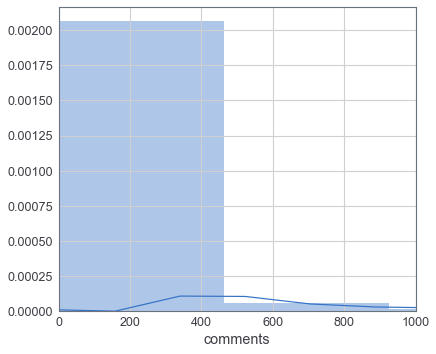

In [114]:
jtplot.style()
# setting axis range in seaborn:
sns.distplot(trainx['comments'], norm_hist=True).set(xlim=(0,1000))


In [115]:
# CountVectorize subreddits to find out which ones are the most common in the dataset.

cvec = CountVectorizer() # no stop_words since its just subreddit names
trainx_counts = cvec.fit_transform(trainx['subreddit'])
xtrainbag = pd.DataFrame(trainx_counts.todense(), 
                         columns=cvec.get_feature_names())
xtrainbag.sum(axis=0).sort_values(ascending=False).head(50)

# make a word cloud here!

the_donald              639
politics                358
ice_poseidon            336
dankmemes               222
me_irl                  197
aww                     176
funny                   157
pewdiepiesubmissions    146
kanye                   127
soccer                  125
nba                     122
memes                   118
animemes                115
fortnitebr              109
prequelmemes            106
ddlc                    105
gaming                   98
tumblr                   95
blackpeopletwitter       93
deepfriedmemes           88
pics                     69
cringeanarchy            65
greentext                63
todayilearned            61
dota2                    59
greatawakening           58
celebs                   58
globaloffensive          57
hmmm                     55
worldnews                54
showerthoughts           54
mildlyinteresting        53
rupaulsdragrace          52
grandorder               52
gifs                     49
2meirl4meirl        

In [116]:
subfreq = dict(xtrainbag.sum(axis=0).sort_values(ascending=False).head(100))

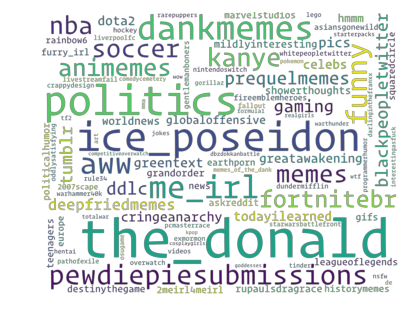

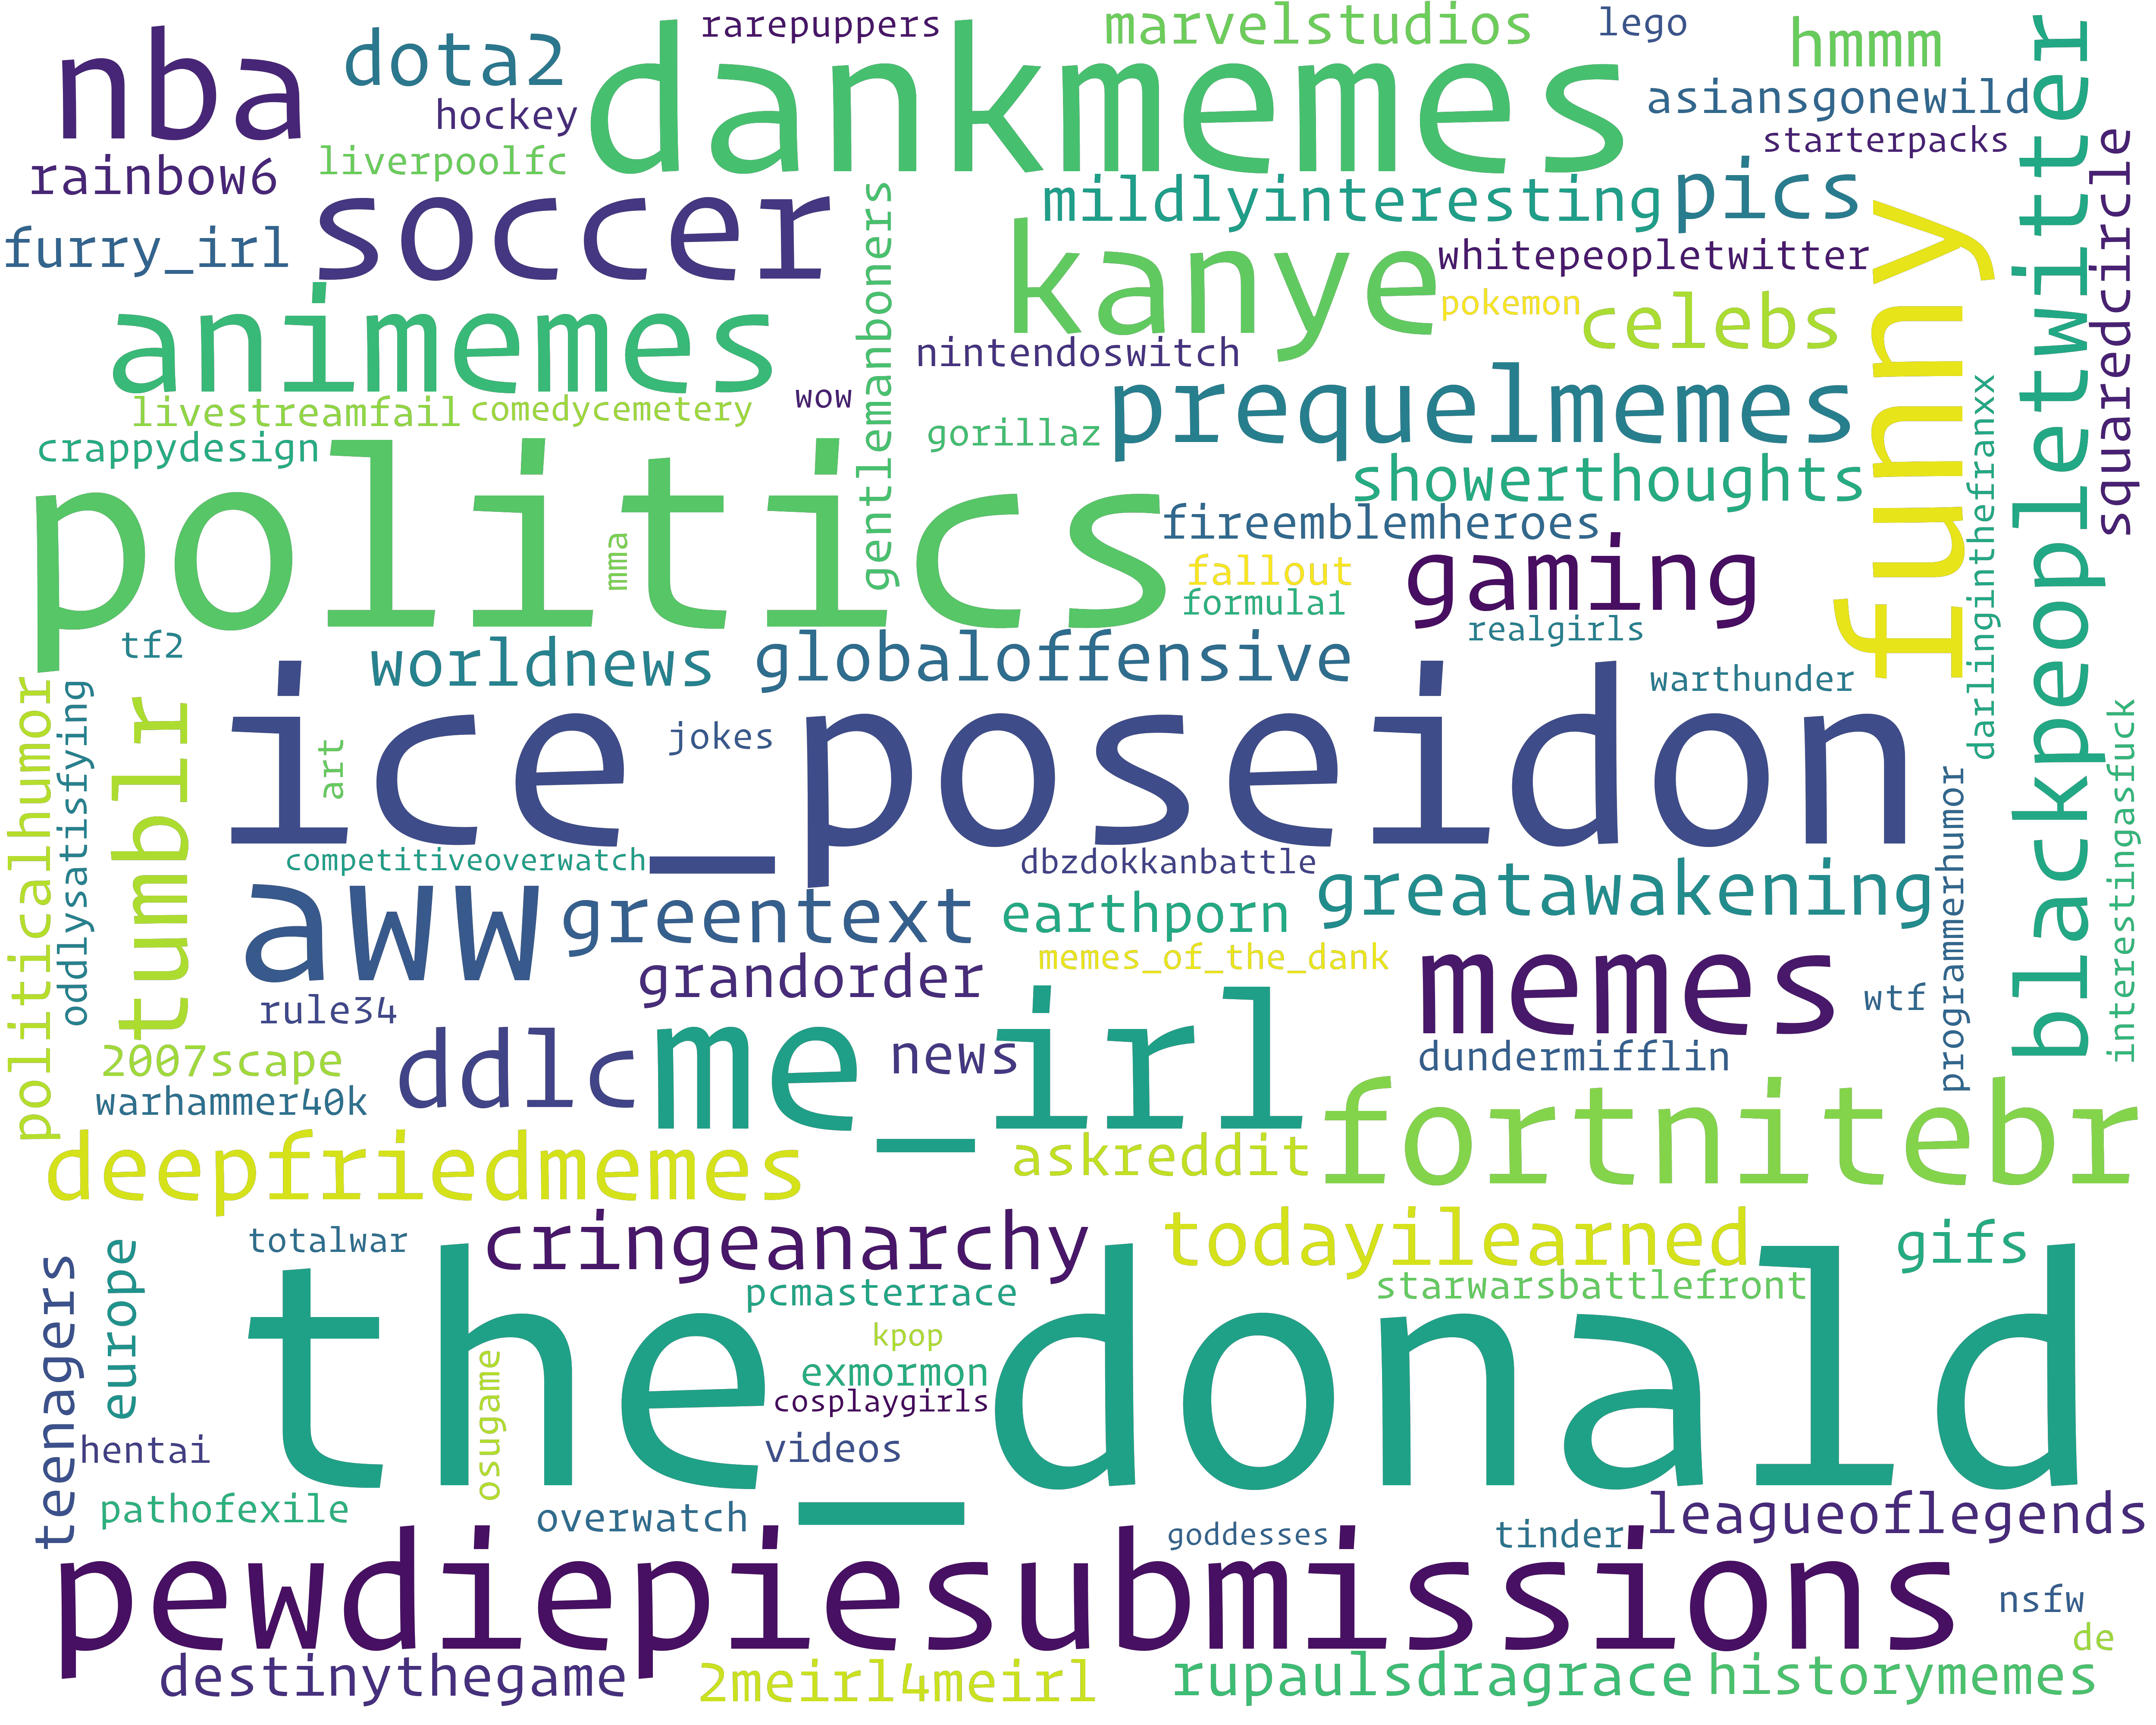

In [118]:
# d = path.dirname('/Users/saqibnizami/notebooks/DSI-US-4/Projects/project-3/')
# mask = np.array(Image.open(path.join(d, "upvote.png")))
# tried to mask the word cloud to a reddit arrow.... didn't work


wordcloud = WordCloud(width=5000, height=4000, margin=5, 
                      font_path="/Users/saqibnizami/Library/Fonts/OperatorMono-Book.otf",
                      background_color=None,
                      mode="RGBA",
                     )
wordcloud.generate_from_frequencies(frequencies=subfreq)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins (x=0, y=0)
plt.show()
# wordcloud.to_file('subreddit_cloud.png')
wordcloud.to_image()

In [119]:
# pipeline to evaluate subreddits vs success

pipe = make_pipeline(CountVectorizer(),
                    RandomForestClassifier(random_state=42))
pipe.fit(trainx['subreddit'], trainy)
pipe.score(testx['subreddit'], testy)

0.7217830478700044

Already better than our baseline. Lets see what features we can
get from a RandomForestClassifier

In [120]:
# # See which features our inital RandomForest model has deemed to be important:

rfc_feats = pipe.steps[1][1].feature_importances_
rfc_featname = pipe.steps[0][1].get_feature_names()
rfc_featrank = pd.DataFrame(data=rfc_feats, index=rfc_featname)
rfc_featrank.rename(columns={0:"importance"}, inplace=True)

In [132]:
rfc_featrank[rfc_featrank["importance"] > 0].sort_values("importance", ascending=False)
# Taking all the non-zero importance subs might be better.

importance
the_donald        1.357843e-02
nba               1.326144e-02
soccer            9.972251e-03
fortnitebr        7.891060e-03
askreddit         5.662059e-03
leagueoflegends   5.546833e-03
tumblr            5.222352e-03
hockey            4.997581e-03
squaredcircle     4.776793e-03
gaming            4.772501e-03
cringeanarchy     4.540631e-03
worldnews         4.328003e-03
destinythegame    4.319278e-03
dota2             4.170499e-03
celebs            4.058506e-03
fallout           4.049771e-03
news              3.733898e-03
videos            3.712540e-03
pcmasterrace      3.704020e-03
nintendoswitch    3.621797e-03
gentlemanboners   3.469514e-03
globaloffensive   3.219839e-03
rainbow6          3.212619e-03
wtf               3.063800e-03
hentai            3.054163e-03
todayilearned     3.016592e-03
cryptocurrency    2.939830e-03
deepfriedmemes    2.879044e-03
ice_poseidon      2.831179e-03
rupaulsdragrace   2.726445e-03
...                        ...
thenewright       4.828150e-11
anllelasagra      4.714440e-11
notakeonlythrow   4.622358e-11
tiltshift         4.587164e-11
overlanding       4.582252e-11
breastenvy        4.439872e-11
asablackman       4.409455e-11
megaten           4.256279e-11
sarajunderwood    4.188611e-11
ihe               4.160127e-11
rottweiler        4.154239e-11
trollxmoms        4.129883e-11
page3glamour      4.115152e-11
bettafish         4.087413e-11
ratemycock        4.006365e-11
azerothporn       3.917506e-11
lesbianactually   3.903085e-11
slavs_squatting   3.811667e-11
karmaconspiracy   3.728967e-11
latexcosplay      3.661156e-11
machinelearning   3.630606e-11
kindafunny        3.606995e-11
lodeddiper        3.601028e-11
anriokita         3.556446e-11
kittengifs        3.469865e-11
notsafefornature  3.406293e-11
tanime            3.395971e-11
emogirls          3.385696e-11
porn_gifs         2.966904e-11
kitty             2.881762e-11

[2743 rows x 1 columns]

In [138]:
rfc_subs = {}
rfcsubdf = rfc_featrank[rfc_featrank["importance"] > 0].sort_values("importance", ascending=False)
rfcsubdf['subreddits'] = rfcsubdf.index

In [139]:
rfcsubdf = rfcsubdf.reset_index().drop(columns='index')

In [140]:
for x in rfcsubdf.index:
    rfc_subs[rfcsubdf.iloc[x,1]] = rfcsubdf.iloc[x,0]

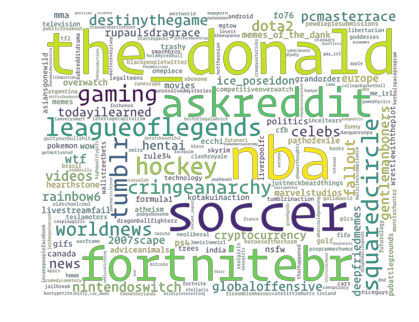

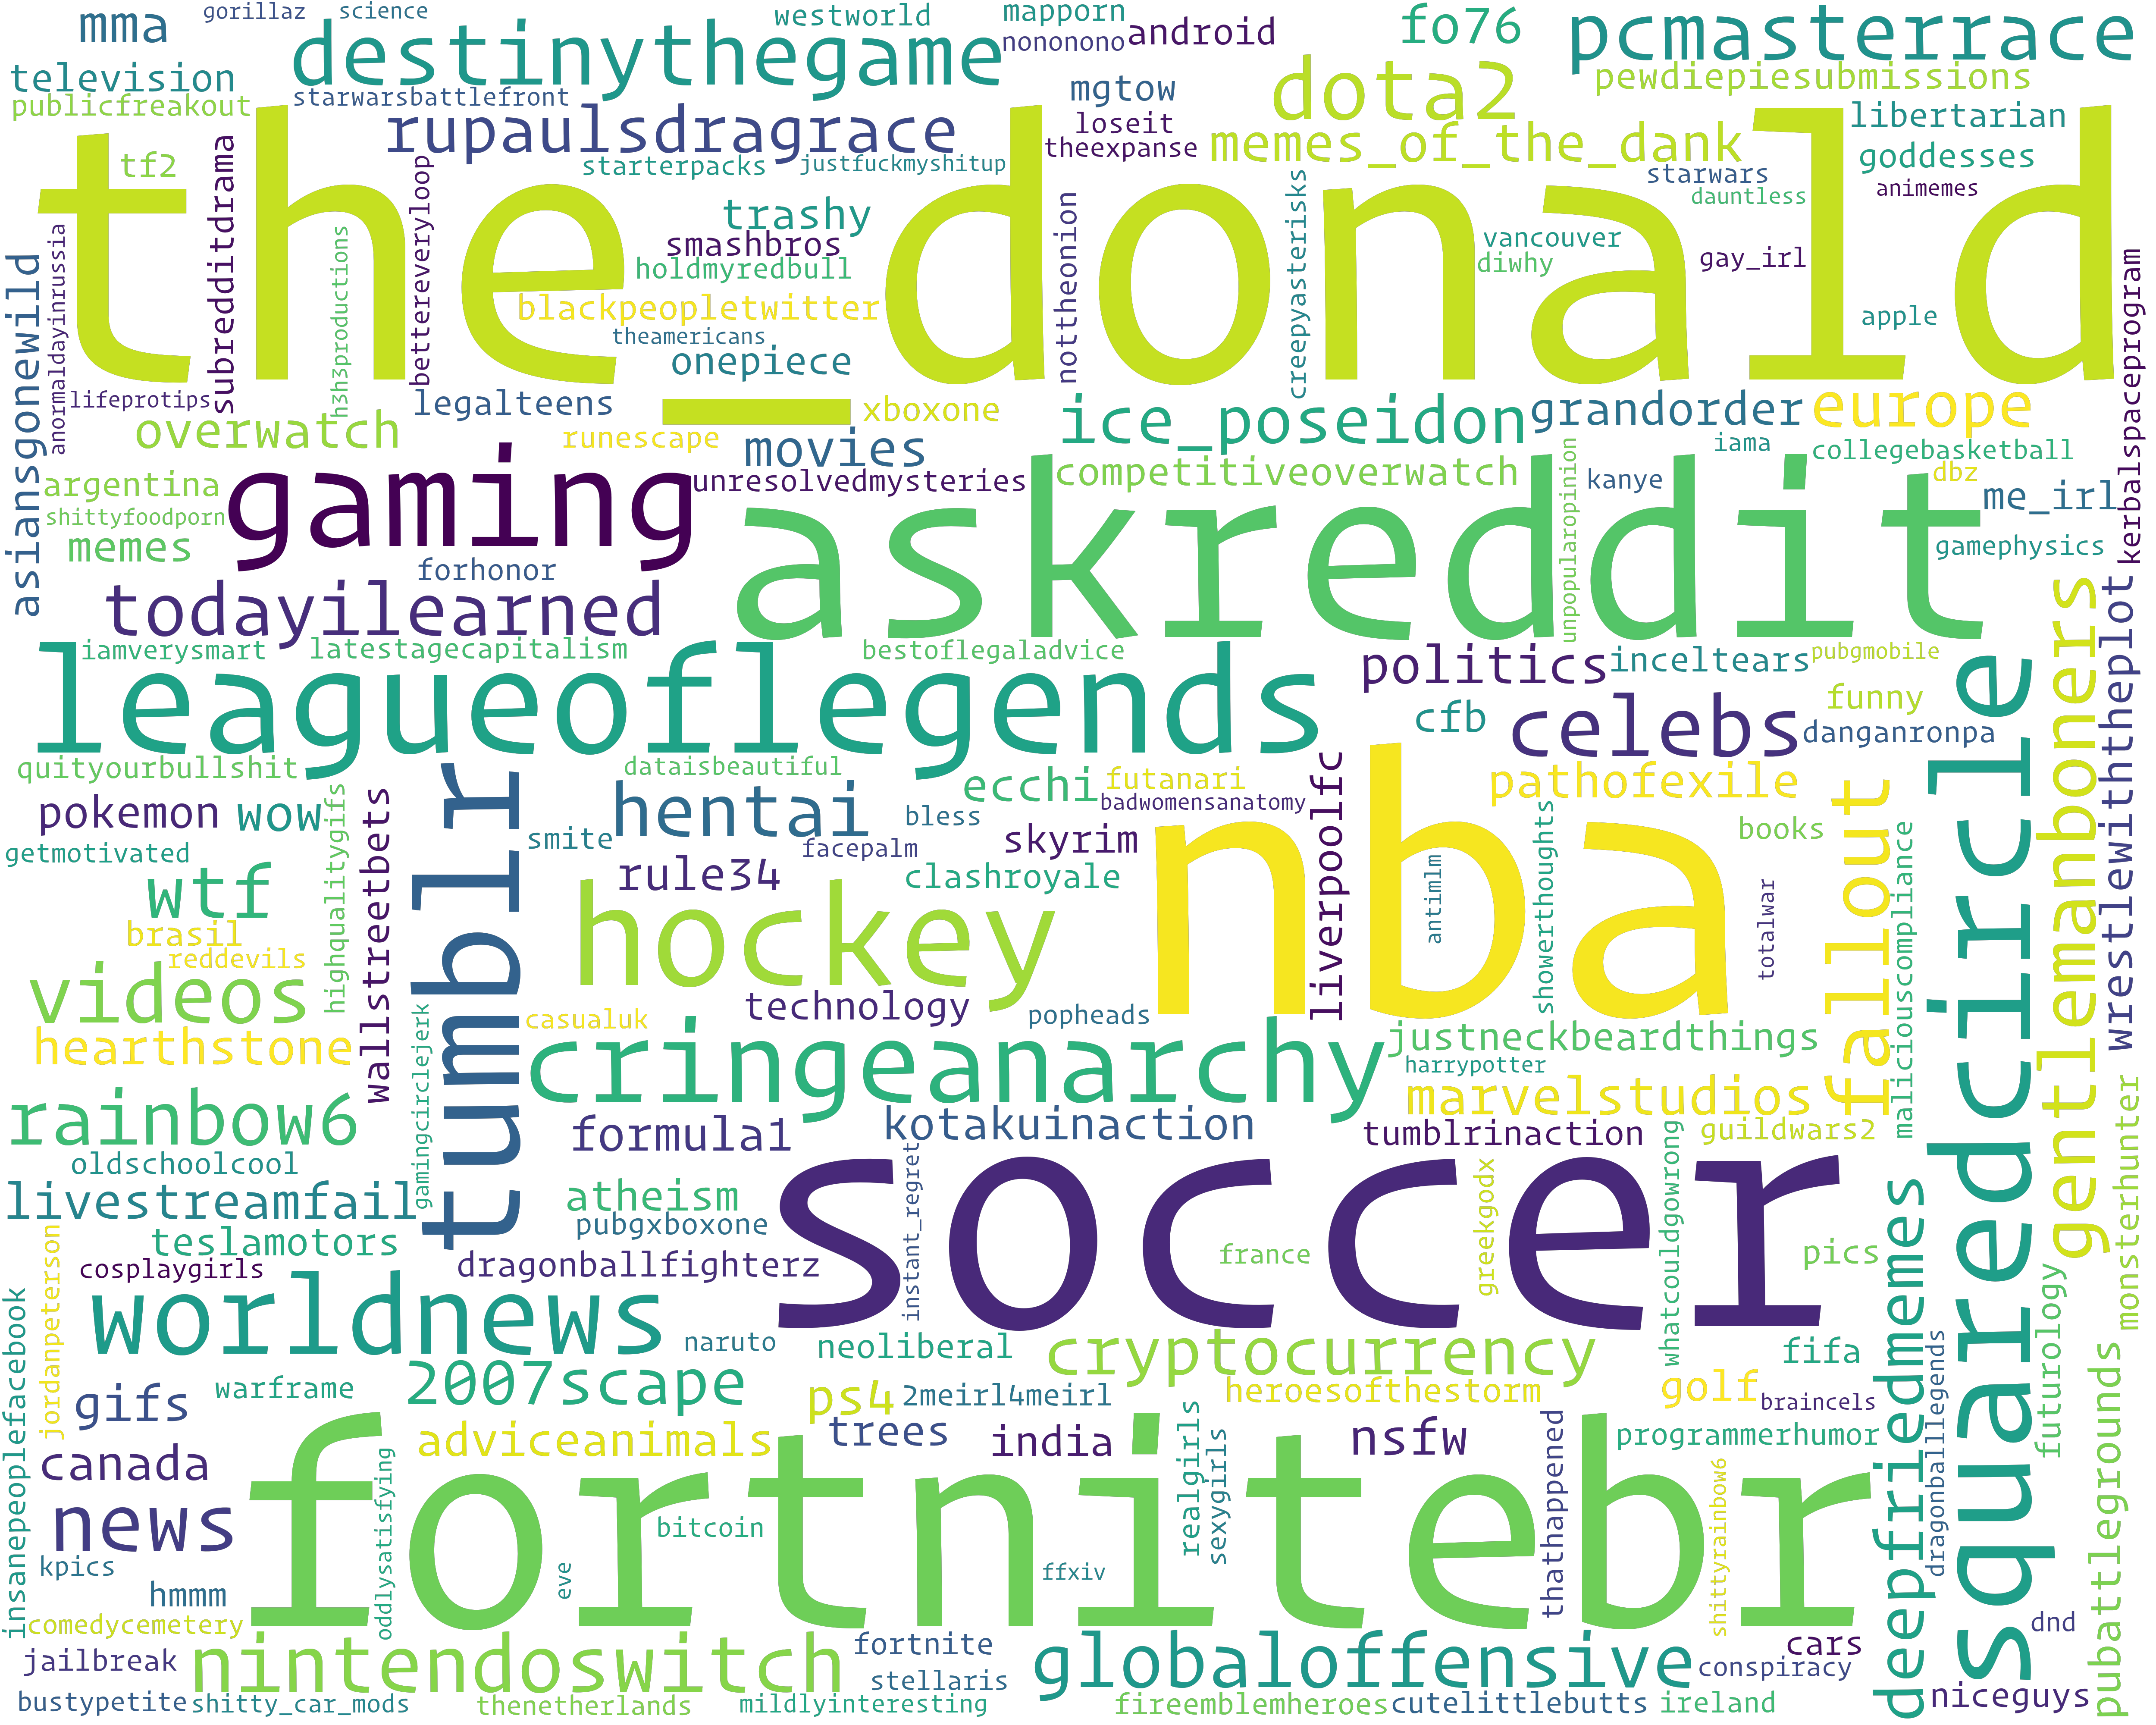

In [111]:
wordcloud = WordCloud(width=5000, height=4000, margin=5, 
                      font_path="/Users/saqibnizami/Library/Fonts/OperatorMono-Book.otf",
                      background_color=None,
                      mode="RGBA",
                     )
wordcloud.generate_from_frequencies(frequencies=rfc_subs)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins (x=0, y=0)
plt.show()
# wordcloud.to_file('subreddit_cloud.png')
wordcloud.to_image()

In [133]:
# make a list to filter down dataset later
top_subs = list(rfc_featrank[rfc_featrank["importance"] > 0].sort_values("importance", ascending=False).index)
#might need more than 
len(top_subs)

2743

In [141]:
trainx.sort_values('comments', ascending=False)

# a comment/score ratio might be a good feature to determine active participation
comrat = []
for x in trainx.index:
    comrat.append((trainx['comments'][x])/(trainx['score'][x]))
trainx['comment_ratio']=comrat

In [142]:
display(trainx.sort_values("comment_ratio", ascending=False))
# self posts seem to have the highest comment_ratio, another feature could be 'is_self'

comments       created  crossposts                    domain  gilded  \
418       21146  1.527748e+09           0               self.hockey       0   
20055      1051  1.527905e+09           0               self.soccer       0   
11492       647  1.527799e+09           0                 salon.com       0   
19488      1234  1.527908e+09           0               self.soccer       0   
17993      1358  1.527854e+09           0             self.warriors       0   
18616       374  1.527891e+09           1             money.cnn.com       0   
9160        304  1.527794e+09           0           self.realmadrid       0   
10217       769  1.527770e+09           0           self.grandorder       0   
10778       264  1.527806e+09           0             pbs.twimg.com       0   
18186       425  1.527887e+09           0               youtube.com       0   
6216        500  1.527791e+09           0    poll.forumresearch.com       0   
7324        393  1.527790e+09           1                    nos.nl       0   
6434        291  1.527788e+09           0              self.houston       0   
6313        329  1.527801e+09           0               youtube.com       0   
4391        354  1.527808e+09           2  self.elderscrollslegends       0   
4049        537  1.527796e+09           0              uploadvr.com       0   
17062       606  1.527907e+09           0                  self.wow       0   
17137       204  1.527894e+09           0               youtube.com       0   
9180        391  1.527797e+09           0               self.hockey       0   
5380        297  1.527801e+09           1               twitter.com       0   
18912       168  1.527893e+09           0      self.leagueoflegends       0   
7885        243  1.527777e+09           0                  self.btc       0   
9208        341  1.527789e+09           0       businessinsider.com       0   
18862       107  1.527904e+09           0          self.pathofexile       0   
7739       1016  1.527762e+09           0           pathofexile.com       0   
10718       144  1.527797e+09           0               twitter.com       0   
17537       253  1.527887e+09           0      kitchener.ctvnews.ca       0   
20074        78  1.527896e+09           0                  self.nba       0   
8328        180  1.527803e+09           0          self.teslamotors       0   
16151       273  1.527896e+09           0           self.conspiracy       0   
...         ...           ...         ...                       ...     ...   
17283         0  1.527892e+09           0                 imgur.com       0   
9791          0  1.527798e+09           0                 i.redd.it       0   
2260          0  1.527735e+09           0                gfycat.com       0   
4174          0  1.527796e+09           0               i.imgur.com       0   
8220          0  1.527787e+09           0                 i.redd.it       0   
9568          0  1.527811e+09           0               i.imgur.com       0   
8295          0  1.527783e+09           0                 i.redd.it       0   
6690          0  1.527806e+09           0                 i.redd.it       0   
16100         0  1.527892e+09           0               i.imgur.com       0   
17221         0  1.527898e+09           0                 i.redd.it       0   
5690          0  1.527793e+09           0                 i.redd.it       0   
7587          0  1.527781e+09           0                 i.redd.it       0   
4880          0  1.527793e+09           0               i.imgur.com       0   
10979         0  1.527809e+09           0                 i.redd.it       0   
8684          0  1.527809e+09           0                 i.redd.it       0   
9899          0  1.527799e+09           0                 i.redd.it       0   
9997          0  1.527808e+09           0               i.imgur.com       0   
8499          0  1.527788e+09           0               i.imgur.com       0   
15374         0  1.527882e+09           0                

In [143]:
trainx.query("over50p == 0").sort_values("comment_ratio", ascending=False)

comments       created  crossposts                 domain  gilded  \
15883        27  1.527895e+09           0            twitter.com       0   
19018        28  1.527900e+09           0      odditycentral.com       0   
10349        29  1.527798e+09           0    self.greatawakening       0   
11325        31  1.527798e+09           1          bloomberg.com       0   
16011        27  1.527895e+09           0   self.fantasybaseball       0   
8600         22  1.527808e+09           0              i.redd.it       0   
16334        28  1.527893e+09           0       bernardmedia.org       0   
9896         13  1.527809e+09           0            nbcnews.com       0   
9859         13  1.527810e+09           0              i.redd.it       0   
6141         28  1.527801e+09           0              self.dogs       0   
7515         31  1.527807e+09           0             ctvnews.ca       0   
16818        18  1.527895e+09           0             gfycat.com       0   
5505         30  1.527803e+09           0                nhl.com       0   
19564        28  1.527907e+09           0              i.redd.it       0   
17495        31  1.527899e+09           0            youtube.com       0   
20484        30  1.527896e+09           0        nydailynews.com       0   
11489        12  1.527804e+09           0                npr.org       0   
5824         26  1.527804e+09           0           sportsnet.ca       0   
7245         22  1.527795e+09           0             self.gwent       0   
18604        26  1.527892e+09           0              vimeo.com       0   
5728         27  1.527794e+09           0  developer.android.com       0   
18229        28  1.527889e+09           0              i.redd.it       0   
9395         30  1.527799e+09           0              i.redd.it       0   
20503        17  1.527905e+09           1                cnn.com       0   
8937         12  1.527806e+09           0              i.redd.it       0   
5642         28  1.527800e+09           0              gotham.rs       0   
2305         24  1.527744e+09           0            twitter.com       0   
6040         26  1.527804e+09           0           sportsnet.ca       0   
2273         24  1.527744e+09           0            twitter.com       0   
5969         26  1.527803e+09           0             self.piano       0   
...         ...           ...         ...                    ...     ...   
16779         0  1.527899e+09           0              i.redd.it       0   
15908         0  1.527883e+09           0              i.redd.it       0   
8913          0  1.527794e+09           0              i.redd.it       0   
6946          0  1.527797e+09           0            i.imgur.com       0   
7627          0  1.527794e+09           0            i.imgur.com       0   
10786         0  1.527810e+09           0              v.redd.it       0   
14627         0  1.527891e+09           0             gfycat.com       0   
17445         0  1.527879e+09           0            i.imgur.com       0   
16202         0  1.527883e+09           0              imgur.com       0   
6534          0  1.527798e+09           0              i.redd.it       0   
8295          0  1.527783e+09           0              i.redd.it       0   
6584          0  1.527793e+09           0       commondreams.org       0   
8093          0  1.527799e+09           0              i.redd.it       0   
16100         0  1.527892e+09           0            i.imgur.com       0   
17566         0  1.527886e+09           0              imgur.com       0   
7664          0  1.527769e+09           0              i.redd.it       0   
7385          0  1.527793e+09           0            i.imgur.com       0   
14763         0  1.527886e+09           0              imgur.com       0   
8684          0  1.527809e+09           0              i.redd.it       0   
16134         0  1.527895e+09           0              i.redd.it       0   
15240         0  1.527889e+09           0            po

In [148]:
comratdf =  trainx.query("over50p == 1").sort_values("comment_ratio", ascending=False).iteritems()
for x in comratdf:
    print(comratdf[x])

TypeError: 'generator' object is not subscriptable

In [ ]:
trainx.query("comment_ratio >= 1 & over50p == 0").sort_values("comment_ratio", ascending=False)

# comment ratio might be another possible target, along with over25p and over75p, these and created should be dropped from the dataset going forward.


In [ ]:
# comtesty = pd.Series()
# comrat = []
# for x in testx.index:
#     comrat.append((testx['comments'][x])/(testx['score'][x]))
# comtesty['comment_ratio']=comrat
# comtesty.values

# comtrainy = trainx["comment_ratio"]


# pipe = make_pipeline(CountVectorizer(),
#                     LinearRegression())
# pipe.fit(trainx['subreddit'], comtrainy.values)
# pipe.score(testx['subreddit'], comtesty.values)

In [22]:
is_self = []
for x in trainx['domain']:
    if bool(re.match(r"(^self.*)", x)) == True:
        is_self.append(1)
    else:
        is_self.append(0)


trainx['is_self'] = is_self

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [23]:
# check
trainx[trainx.domain.str.contains(r"(^self.*)") == True].shape[0]/trainx.shape[0]

# self posts comprise10% of the dataset
    

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



0.09652446055015648

In [24]:
trainx = trainx.drop(columns=["comments","created","over25p","over50p","over75p"])

In [25]:
display(trainx.shape, trainx.head())

(18213, 10)

crossposts     domain  gilded  score          subreddit  \
19058           1  i.redd.it       0   7240         FortNiteBR   
15420           0  i.redd.it       0    654  ShitPostCrusaders   
22607           0  i.redd.it       0   2047  PropagandaPosters   
20418           0  imgur.com       0     49       Ice_Poseidon   
10071           0  v.redd.it       0    314    rupaulsdragrace   

                                                   title  upvote_ratio  \
19058                                LTM Idea: Prop Hunt          0.91   
15420                                  Rate my prom tie.          0.98   
22607  "Indie Must Be Free! Work and Fight for it!", ...          0.98   
20418   Found mugshot of Brandon's brother Robert Grosso          0.83   
10071  throwback to aquaria's most ICONIC (and nude) ...          0.96   

                timestamp  comment_ratio  is_self  
19058 2018-06-01 03:11:12       0.038398        0  
15420 2018-06-01 21:30:53       0.070336        0  
22607 2018-06-01 13:52:05       0.050318        0  
20418 2018-06-01 21:06:48       0.306122        0  
10071 2018-05-31 08:16:34       0.181529        0

In [134]:
# What does the dataframe look like with the top subreddits only
trainx = trainx[trainx.subreddit.isin(top_subs) == True]

In [135]:
trainx.shape

(8989, 13)

In [136]:
pipe = make_pipeline(CountVectorizer(),
                    RandomForestClassifier(random_state=42))
pipe.fit(trainx['subreddit'], trainy)
pipe.score(testx['subreddit'], testy)

ValueError: Number of labels=18213 does not match number of samples=8989

## Bag up the titles

In [31]:
# build on our subreddit findings: adjust our dataset before analyzing titles:
print(df.shape, y.shape)

(22767, 13) (22767,)


In [32]:
df.head()

comments       created  crossposts       domain  gilded  score  \
0       268  1.527746e+09           1    i.redd.it       0  54696   
1      3771  1.527740e+09           2  thehill.com       0  39344   
2      3232  1.527744e+09           4  youtube.com       5  83372   
3      2439  1.527740e+09           6   smh.com.au       0  61556   
4       275  1.527748e+09           0    i.redd.it       0  31701   

             subreddit                                              title  \
0  BikiniBottomTwitter  About to make a splash? More like just about t...   
1             politics  FBI is reconstructing shredded documents obtai...   
2               videos  Gamer bet if the new Bethesda reveal was not F...   
3            worldnews  Police faked 258,000 breath tests in shocking ...   
4         PrequelMemes               Always 2 there are, no more, no less   

   upvote_ratio           timestamp  over25p  over50p  over75p  
0          0.82 2018-05-31 01:59:13        1        1        1  
1          0.89 2018-05-31 00:20:29        1        1        1  
2          0.78 2018-05-31 01:14:48        1        1        1  
3          0.89 2018-05-31 00:14:09        1        1        1  
4          0.85 2018-05-31 02:31:16        1        1        1

In [33]:
def train2test(trainx):
    # a comment/score ratio might be a good feature to determine active participation
    comrat = []
    for x in trainx.index:
        comrat.append((trainx['comments'][x])/(trainx['score'][x]))
    trainx['comment_ratio']=comrat

    is_self = []
    for x in trainx['domain']:
        if bool(re.match(r"(^self.*)", x)) == True:
            is_self.append(1)
        else:
            is_self.append(0)


    trainx['is_self'] = is_self



train2test(df)


y = df['over50p']
print(df.shape, y.shape)
# titlepipe = Pipeline([
#     ('cvec', CountVectorizer(stop_words="english")),
#     ('lr', LogisticRegression(random_state=42))
# ])
# params = {
#     "cvec__ngram_range" : [(1,1),(1,2)],
#     "cvec__max_df" : [0.85,0.9,0.95,1],
#     "lr__penalty": ["l1","l2"],
# #     "lr__C" : [0.25,0.50,0.75,1.0,1.25,1.50,1.75,2],
#     "lr__solver" : ["newton-cg","liblinear"]
# }

# gs_lr = GridSearchCV(titlepipe, params, cv=5, scoring='accuracy')
# gs_lr.fit(trainx,trainy)
# gs_lr.score(testx,testy)

(22767, 15) (22767,)


In [38]:
df = df.drop(columns=["comments","created","over25p","over75p"])

df.head()

crossposts       domain  gilded  score            subreddit  \
0           1    i.redd.it       0  54696  BikiniBottomTwitter   
1           2  thehill.com       0  39344             politics   
2           4  youtube.com       5  83372               videos   
3           6   smh.com.au       0  61556            worldnews   
4           0    i.redd.it       0  31701         PrequelMemes   

                                               title  upvote_ratio  \
0  About to make a splash? More like just about t...          0.82   
1  FBI is reconstructing shredded documents obtai...          0.89   
2  Gamer bet if the new Bethesda reveal was not F...          0.78   
3  Police faked 258,000 breath tests in shocking ...          0.89   
4               Always 2 there are, no more, no less          0.85   

            timestamp  over50p  comment_ratio  is_self  
0 2018-05-31 01:59:13        1       0.004900        0  
1 2018-05-31 00:20:29        1       0.095847        0  
2 2018-05-31 01:14:48        1       0.038766        0  
3 2018-05-31 00:14:09        1       0.039622        0  
4 2018-05-31 02:31:16        1       0.008675        0

In [39]:
df = df[df.subreddit.isin(top_subs) == True]

In [50]:
df.shape
y = df['over50p']

KeyError: 'over50p'

In [44]:
df = df.drop(columns="over50p")

In [51]:
print(df.shape, y.shape)

(11146, 10) (11146,)


In [64]:
y = pd.DataFrame(y)
y.shape

(11146, 1)

In [65]:
trainx, testx, trainy, testy = train_test_split(df, y, test_size=.20,
                                                    random_state=19)

print(trainx.shape, trainy.shape, testx.shape, testy.shape)

(8916, 10) (8916, 1) (2230, 10) (2230, 1)


In [102]:
cvec = CountVectorizer(stop_words='english', ngram_range=(1,2), lowercase=True)
trainXtitles = pd.DataFrame(cvec.fit_transform(trainx['title']).todense(), 
                            columns=cvec.get_feature_names())
testXtitles = pd.DataFrame(cvec.fit_transform(testx['title']).todense(), 
                            columns=cvec.get_feature_names())

In [103]:
cvec.build_analyzer()
title = "".join(df.title)
ngramsnums = cvec.build_analyzer()(title)
Counter(ngramsnums).most_common(20)

[]

In [90]:
cvec = CountVectorizer(stop_words='english', ngram_range=(2,4), lowercase=True)
trainXtitles = pd.DataFrame(cvec.fit_transform(trainx['title']).todense(), 
                            columns=cvec.get_feature_names())
testXtitles = pd.DataFrame(cvec.fit_transform(testx['title']).todense(), 
                            columns=cvec.get_feature_names())

In [96]:
cvec.build_analyzer()
title = "".join(df.title)
ngramsnums = cvec.build_analyzer()(title)
Counter(ngramsnums).most_common(20)

[('year old', 32),
 ('looks like', 26),
 ('years ago', 20),
 ('steel aluminum', 20),
 ('real madrid', 20),
 ('world cup', 18),
 ('donald trump', 18),
 ('lebron james', 17),
 ('white house', 17),
 ('infinity war', 15),
 ('look like', 15),
 ('don know', 15),
 ('trade war', 14),
 ('best friend', 13),
 ('fallout 76', 13),
 ('dinesh souza', 13),
 ('spider man', 12),
 ('aluminum tariffs', 12),
 ('social media', 12),
 ('jr smith', 12)]

In [92]:
titlengrams = Counter(ngramsnums).most_common(20)

In [99]:
titlengramlist= []
for x,i in titlengrams:
    titlengramlist.append(x)

In [151]:
titlengramlist

['year old',
 'looks like',
 'years ago',
 'steel aluminum',
 'real madrid',
 'world cup',
 'donald trump',
 'lebron james',
 'white house',
 'infinity war',
 'look like',
 'don know',
 'trade war',
 'best friend',
 'fallout 76',
 'dinesh souza',
 'spider man',
 'aluminum tariffs',
 'social media',
 'jr smith']

In [101]:
df = df[df.title.isin(titlengramlist) == True]
df.head()

Empty DataFrame
Columns: [crossposts, domain, gilded, score, subreddit, title, upvote_ratio, timestamp, comment_ratio, is_self]
Index: []

In [75]:
cvec = CountVectorizer(stop_words='english', ngram_range=(4,4), lowercase=True)
trainXtitles = pd.DataFrame(cvec.fit_transform(trainx['title']).todense(), 
                            columns=cvec.get_feature_names())
testXtitles = pd.DataFrame(cvec.fit_transform(testx['title']).todense(), 
                            columns=cvec.get_feature_names())

In [76]:
cvec.build_analyzer()
title = "".join(df.title)
ngramsnums = cvec.build_analyzer()(title)
Counter(ngramsnums).most_common(20)

[('trump like talking toddler', 8),
 ('faked 258 000 breath', 6),
 ('meeting trump like talking', 6),
 ('police faked 258 000', 5),
 ('feigen tucker played game', 5),
 ('tucker played game root', 5),
 ('played game root canals', 5),
 ('game root canals didn', 5),
 ('root canals didn tell', 5),
 ('canals didn tell teammates', 5),
 ('tфяonγф cфmprфmise hдs бeξи', 5),
 ('cфmprфmise hдs бeξи mдde', 5),
 ('hдs бeξи mдde pядisξd', 5),
 ('бeξи mдde pядisξd бe', 5),
 ('mдde pядisξd бe γфroиtщф', 5),
 ('pядisξd бe γфroиtщф aиd', 5),
 ('бe γфroиtщф aиd evξяlastiиg', 5),
 ('pardon conservative pundit dinesh', 5),
 ('conservative pundit dinesh souza', 5),
 ('holtby game save cartoon', 5)]

In [73]:
trainy = np.ravel(trainy)

In [ ]:
rf = RandomForestClassifier(random_state=42)
nbm = MultinomialNB()
lr = LogisticRegression(random_state=42)

In [81]:
testy = np.ravel(testy)

In [82]:
score = cross_val_score(lr, testXtitles, testy, cv = 5, verbose = 1)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


In [84]:
print('mean: {} std: +/- {}'.format(np.mean(score), np.std(score)))

mean: 0.4919252054503304 std: +/- 0.0030512149421470895


In [ ]:
gs = GridSearchCV()

In [74]:
nbm.fit(trainXtitles, trainy)
nbm.predict(testXtitles)

ValueError: shapes (2230,22673) and (80346,2) not aligned: 22673 (dim 1) != 80346 (dim 0)

In [85]:
pipe = Pipeline([
    ("cvec", CountVectorizer()),
    ("nb", MultinomialNB())])


params = {
    "cvec__ngram_range": (2, 4),
    
}

gs_rfc = GridSearchCV(pipe, params, cv=5).fit(trainx, trainy)
print("Score:", gs_rfc.score(testx,testy))


print("Cross Validation Results: \n\n", 
      gs_rfc.cv_results_, '\n\n',
     "Best score: \n\n",
     gs_rfc.best_score_, '\n\n',
     "Best parameters:",
     gs_rfc.best_params_, '\n\n',
     "Best estimator:\n\n",
     gs_rfc.best_estimator_,'\n\n',)

TypeError: 'int' object is not iterable

In [56]:
lr_pipe = Pipeline([
    ("cvec", CountVectorizer()),
    ("tf", TfidfTransformer()),
    ("lr", LogisticRegression(random_state=19, n_jobs=2))])
params = {}
gs_lr = GridSearchCV(lr_pipe, params, cv=5).fit(trainx['title'],trainy)
print("Score:", gs_lr.score(testx['title'],testy))


print("Cross Validation Results: \n\n", 
      gs_lr.cv_results_, '\n\n',
     "Best score: \n\n",
     gs_lr.best_score_, '\n\n',
     "Best parameters:",
     gs_lr.best_params_, '\n\n',
     "Best estimator:\n\n",
     gs_lr.best_estimator_,'\n\n',)

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning:

'n_jobs' > 1 does not have an

Score: 0.6300448430493274
Cross Validation Results: 

 {'mean_fit_time': array([0.17724233]), 'std_fit_time': array([0.03020312]), 'mean_score_time': array([0.02782826]), 'std_score_time': array([0.00592287]), 'params': [{}], 'split0_test_score': array([0.64517937]), 'split1_test_score': array([0.64441952]), 'split2_test_score': array([0.63488503]), 'split3_test_score': array([0.6517106]), 'split4_test_score': array([0.64722378]), 'mean_test_score': array([0.64468371]), 'std_test_score': array([0.00551619]), 'rank_test_score': array([1], dtype=int32), 'split0_train_score': array([0.8482894]), 'split1_train_score': array([0.84592738]), 'split2_train_score': array([0.85041357]), 'split3_train_score': array([0.85125473]), 'split4_train_score': array([0.84522641]), 'mean_train_score': array([0.8482223]), 'std_train_score': array([0.00237671])} 

 Best score: 

 0.6446837146702558 

 Best parameters: {} 

 Best estimator:

 Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.



In [89]:
trainXtitles.sum().sort_values(ascending=False).head()

faked 258 000 breath                 6
police faked 258 000                 6
258 000 breath tests                 6
petition change upvotes downvotes    5
trump like talking toddler           5
dtype: int64

In [60]:
lr_pipe = Pipeline([
    ("cvec", CountVectorizer()),
    ("tf", TfidfTransformer()),
    ("lr", LogisticRegression(random_state=19, n_jobs=2))])
params = {}

gs_lr = GridSearchCV(lr_pipe, params, cv=5).fit(trainx,trainy)
print("Score:", gs_lr.score(testx,testy))


print("Cross Validation Results: \n\n", 
      gs_lr.cv_results_, '\n\n',
     "Best score: \n\n",
     gs_lr.best_score_, '\n\n',
     "Best parameters:",
     gs_lr.best_params_, '\n\n',
     "Best estimator:\n\n",
     gs_lr.best_estimator_,'\n\n',)

ValueError: Found input variables with inconsistent numbers of samples: [10, 7132]

### Vectorize titles and add them to the model.

In [ ]:
# Bag of words for titles

cvec = CountVectorizer(stop_words='english', ngram_range=)
trainx_title_count = cvec.fit_transform(trainx['title'])
traintitle = pd.DataFrame(trainx_title_count.todense(), columns=cvec.get_feature_names())
traintitle.sum(axis=0).sort_values(ascending=False).head(20)

In [ ]:
trainx.shape

In [ ]:
# We can probably get a better idea by upping the ngram range:
cvec = CountVectorizer(stop_words='english', ngram_range=(1,3))
trainx_title_count = cvec.fit_transform(trainx['title'])
traintitle = pd.DataFrame(trainx_title_count.todense(), columns=cvec.get_feature_names())
traintitle.sum(axis=0).sort_values(ascending=False).head(20)

In [ ]:
class ItemSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    

In [ ]:
# make pipelines for each column
# comments = Pipeline([
#     ('select', ItemSelector(key='comments'),
#     ('std', StandardScaler()))
# ])
# score = Pipeline([
#     ('select', ItemSelector(key='score'),
#     ('std', StandardScaler()))
# ])
# upvote = Pipeline([
#     ('select', ItemSelector(key='upvote_ratio'),
#     ('std', StandardScaler()))
# ])
domain = Pipeline([
    ('select', ItemSelector(key='domain')),
    ('cvec', CountVectorizer()),
    ('tft', TfidfTransformer())
])
subreddit = Pipeline([
    ('select', ItemSelector(key='subreddit')),
    ('cvec', CountVectorizer()),
    ('tft', TfidfTransformer())
])
title = Pipeline([
    ('select', ItemSelector(key='domain')),
    ('cvec', CountVectorizer()),
    ('tft', TfidfTransformer())
])

# FeatureUnion-ize the column pipes
colpipes = FeatureUnion([("domain", domain),
                         ("subreddit", subreddit),
                         ("title", title)])
# master pipes
pipe_rf = Pipeline([
    ('colpipes',colpipes),
    ('clf', RandomForestClassifier(random_state=42))
])
pipe_rf.fit(trainx, trainy)
print("Score RFC: ", pipe_rf.score(testx, testy))

pipe_lr = Pipeline([
    ('colpipes',colpipes),
    ('clf', LogisticRegression(random_state=42))
])
pipe_lr.fit(trainx, trainy)
print("Score LogReg: ", pipe_lr.score(testx, testy))



In [ ]:
pipe_rf.named_steps['clf'].classes_

In [ ]:
headers = ["name", "score"]
values = sorted(zip(trainx.columns, pipe_rf.named_steps['clf'].feature_importances_), key=lambda x: x[1] * -1)
featimp = pd.DataFrame(values, columns=['feature', 'score'])
featimp

In [ ]:
gs = GridSearchCV()

In [ ]:
ItemSelector(trainx, key='comments')